In [5]:
library(ArchR)
addArchRThreads(threads = 16)
addArchRGenome("hg19")
library(BSgenome.Dmelanogaster.UCSC.dm6)


Setting default number of Parallel threads to 16.



Setting default genome to Hg19.

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat




In [10]:
if (!requireNamespace("TxDb.Dmelanogaster.UCSC.dm6.ensGene", quietly = TRUE)){
  BiocManager::install("TxDb.Dmelanogaster.UCSC.dm6.ensGene")
}
if (!requireNamespace("org.Dm.eg.db", quietly = TRUE)){
  BiocManager::install("org.Dm.eg.db")
}
library(TxDb.Dmelanogaster.UCSC.dm6.ensGene)
library(org.Dm.eg.db)

In [6]:
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.Dmelanogaster.UCSC.dm6)

Getting genome..

Attempting to infer chromSizes..

Attempting to infer blacklist..

Blacklist not downloaded! Continuing without, be careful for downstream biases..



In [11]:
geneAnnotation <- createGeneAnnotation(TxDb = TxDb.Dmelanogaster.UCSC.dm6.ensGene, OrgDb = org.Dm.eg.db)

Getting Genes..

  1 gene was dropped because it has exons located on both strands of the
  same reference sequence or on more than one reference sequence, so
  cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Determined Annotation Style = ENSEMBL

Getting Exons..

Getting TSS..



In [12]:
geneAnnotation <- createGeneAnnotation(
  TSS = geneAnnotation$TSS, 
  exons = geneAnnotation$exons, 
  genes = geneAnnotation$genes
)

In [13]:
inputFiles <- getTutorialData("Hematopoiesis")
inputFiles

scATAC_BMMC_R1 
     "HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz" 
                                 scATAC_CD34_BMMC_R1 
"HemeFragments/scATAC_CD34_BMMC_R1.fragments.tsv.gz" 
                                      scATAC_PBMC_R1 
     "HemeFragments/scATAC_PBMC_R1.fragments.tsv.gz"

In [14]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  filterTSS = 4, #Dont set this too high because you can always increase later
  filterFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

filterFrags is no longer a valid input. Please use minFrags! Setting filterFrags value to minFrags!

filterTSS is no longer a valid input. Please use minTSS! Setting filterTSS value to minTSS!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-10545e579b3e-Date-2024-08-29_Time-17-23-35.784932.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-08-29 17:23:35.888598 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-10545e579b3e-Date-2024-08-29_Time-17-23-35.784932.log



In [ ]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    LSIMethod = 1
)

In [17]:
projHeme1 <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "HemeTutorial",
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...



Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 


Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-10543656023e-Date-2024-08-29_Time-17-42-36.089566.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-10543656023e-Date-2024-08-29_Time-17-42-36.089566.log



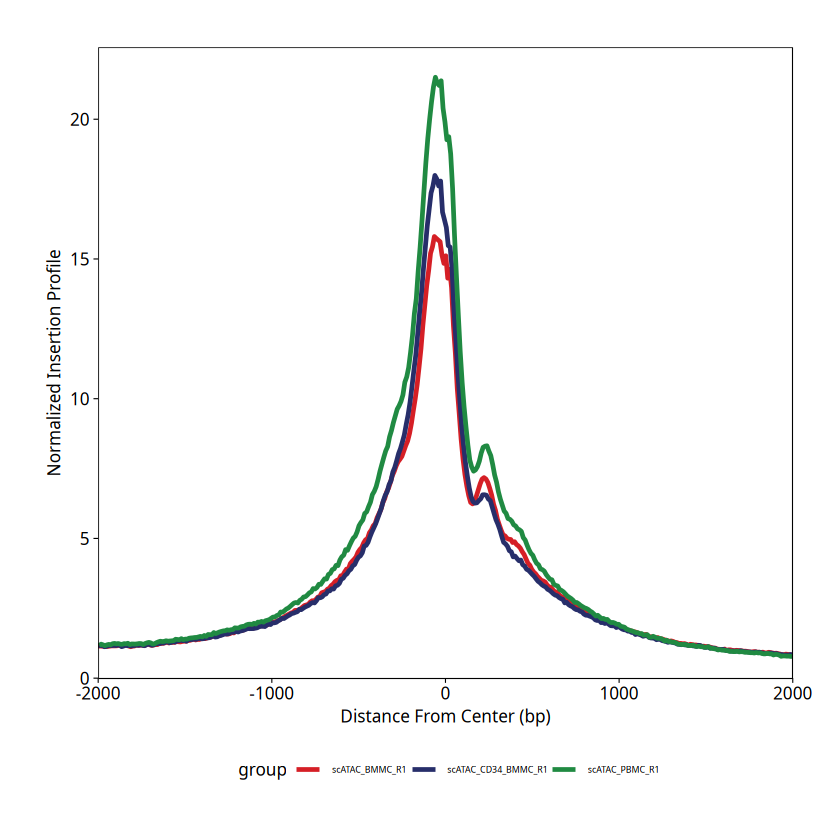

In [29]:
plotTSSEnrichment(ArchRProj = projHeme1)

In [32]:
bioNames <- gsub("_R2|_R1|scATAC_","", projHeme1$Sample)

In [30]:
saveArchRProject(ArchRProj = projHeme1, outputDirectory = "Save-ProjHeme1", load = FALSE)

Copying ArchRProject to new outputDirectory : /home/qp2134/decipher/Save-ProjHeme1

Copying Arrow Files...

Copying Arrow Files (1 of 3)

Copying Arrow Files (2 of 3)

Copying Arrow Files (3 of 3)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Saving ArchRProject...



In [25]:
print(head(projHeme1$Sample))

[1] "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1"
[5] "scATAC_BMMC_R1" "scATAC_BMMC_R1"


In [27]:
print(quantile(projHeme1$TSSEnrichment))

      0%      25%      50%      75%     100% 
 4.10900 13.92550 16.81500 19.93025 41.98000 


In [33]:
projHeme2 <- filterDoublets(projHeme1)

ERROR: Error in value[[3L]](cond): select Not Found in Colnames of cellColData:
[1m[33mError[39m in `dplyr::mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `tmpNewCol123 = eval(parse(text = select[x]))`.
[1mCaused by error:[22m
[33m![39m object 'DoubletEnrichment' not found



In [16]:
markersGS <- getMarkerFeatures(
    ArchRProj = projHeme2, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ERROR: Error in eval(expr, envir, enclos): object 'projHeme2' not found
